# Affine-Invariant Autoencoder Training and Analysis

This notebook trains an autoencoder with an affine transformation branch to disentangle geometric transformations (rotation, skew, translation) from digit identity. The model learns to predict affine transformation parameters that make the reconstruction invariant to geometric changes.

## Architecture Overview
- **Main Branch**: Standard autoencoder for digit reconstruction
- **Affine Branch**: Parallel network that predicts 6 affine transformation parameters
- **Loss Function**: Combines reconstruction loss, affine-invariant loss, and regularization

## Key Features
- Disentangles content (digit identity) from geometric transformations
- Learns invariant representations for rotation, skew, and translation
- Provides interpretable affine transformation parameters

In [6]:
# Auto-reload modules to get latest changes
%load_ext autoreload
%autoreload 2

# Clear any existing model to force reinitialization
import gc
gc.collect()
if 'model' in globals():
    del model
print("Cleared previous model and enabled autoreload")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Cleared previous model and enabled autoreload


In [7]:
# Import all necessary functions from our affine autoencoder module
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Import all classes and functions from our module
from affine_autoencoder import (
    AffineInvariantAutoEncoder,
    AffineTransformationNetwork,
    AutoEncoder,
    train_affine_invariant_autoencoder,
    visualize_affine_results,
    analyze_latent_disentanglement,
    plot_training_progress,
    demonstrate_transformation_invariance,
    get_mnist_loaders,
    get_device,
    save_model,
    load_model
)

print("✅ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.mps.is_available() if hasattr(torch, 'mps') else False}")

✅ All imports successful!
PyTorch version: 2.5.1
CUDA available: False
MPS available: True


In [3]:
# Configuration and Data Loading
device = get_device()

# Training configuration
CONFIG = {
    'latent_dim': 64,           # Latent space dimension for content representation
    'epochs': 25,               # Number of training epochs
    'learning_rate': 1e-3,      # Learning rate
    'alpha': 1.0,               # Weight for reconstruction loss
    'beta': 0.5,                # Weight for affine-invariant loss
    'gamma': 0.01,              # Weight for regularization loss
    'batch_size_train': 128,    # Training batch size
    'batch_size_test': 64,      # Test batch size
    'data_dir': '../data'       # Data directory (relative to affine folder)
}

print("📋 Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

# Load MNIST dataset
print("\n📊 Loading MNIST dataset...")
train_loader, test_loader = get_mnist_loaders(
    batch_size_train=CONFIG['batch_size_train'],
    batch_size_test=CONFIG['batch_size_test'],
    data_dir=CONFIG['data_dir']
)

print(f"Training samples: {len(train_loader.dataset):,}")
print(f"Test samples: {len(test_loader.dataset):,}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Using device: mps
📋 Configuration:
  latent_dim: 64
  epochs: 25
  learning_rate: 0.001
  alpha: 1.0
  beta: 0.5
  gamma: 0.01
  batch_size_train: 128
  batch_size_test: 64
  data_dir: ../data

📊 Loading MNIST dataset...
Training samples: 60,000
Test samples: 10,000
Training batches: 469
Test batches: 157


In [8]:
# Model Initialization
print("🔧 Initializing Affine-Invariant Autoencoder...")

# Initialize the combined model
model = AffineInvariantAutoEncoder(latent_dim=CONFIG['latent_dim'])
model.to(device)

print("\n🏗️  Model Architecture:")
print("="*50)
print("AUTOENCODER BRANCH:")
print(model.autoencoder)
print("\nAFFINE TRANSFORMATION BRANCH:")
print(model.affine_net)
print("="*50)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
autoencoder_params = sum(p.numel() for p in model.autoencoder.parameters())
affine_params = sum(p.numel() for p in model.affine_net.parameters())

print(f"\n📊 Parameter Count:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Autoencoder parameters: {autoencoder_params:,}")
print(f"  Affine network parameters: {affine_params:,}")

# Test forward pass
sample_batch, sample_labels = next(iter(train_loader))
sample_batch = sample_batch[:4].to(device)  # Use 4 samples for testing

print(f"\n🧪 Testing forward pass:")
print(f"  Sample batch shape: {sample_batch.shape}")
print(f"  Data range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")

with torch.no_grad():
    recon, trans_recon, latent, affine_params = model(sample_batch)
    print(f"  Reconstruction shape: {recon.shape}")
    print(f"  Transformed reconstruction shape: {trans_recon.shape}")
    print(f"  Latent shape: {latent.shape}")
    print(f"  Affine parameters shape: {affine_params.shape}")
    print(f"  Sample affine params: {affine_params[0].cpu().numpy()}")

print("✅ Model initialization successful!")

🔧 Initializing Affine-Invariant Autoencoder...

🏗️  Model Architecture:
AUTOENCODER BRANCH:
AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=2048, out_features=512, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=512, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(128, 4, 4))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inp

## Training Phase

Now we'll train the affine-invariant autoencoder. The training process optimizes three loss components:

1. **Reconstruction Loss** (α): Standard autoencoder reconstruction
2. **Affine-Invariant Loss** (β): Ensures transformed reconstruction matches original
3. **Regularization Loss** (γ): Prevents extreme affine transformations

The model learns to:
- Encode digit identity in the latent space (content)
- Predict geometric transformations separately (affine parameters)
- Reconstruct the original image by applying inverse transformations

In [9]:
# Train the Affine-Invariant Autoencoder
print("🚀 Starting Affine-Invariant Autoencoder Training...")
print(f"Training for {CONFIG['epochs']} epochs with:")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Loss weights - α (recon): {CONFIG['alpha']}, β (affine): {CONFIG['beta']}, γ (reg): {CONFIG['gamma']}")

# Train the model
losses_dict = train_affine_invariant_autoencoder(
    model=model,
    train_loader=train_loader,
    epochs=CONFIG['epochs'],
    lr=CONFIG['learning_rate'],
    alpha=CONFIG['alpha'],
    beta=CONFIG['beta'],
    gamma=CONFIG['gamma']
)

print(f"\n✅ Training completed!")
print(f"Final losses:")
print(f"  Total: {losses_dict['total_losses'][-1]:.6f}")
print(f"  Reconstruction: {losses_dict['recon_losses'][-1]:.6f}")
print(f"  Affine-Invariant: {losses_dict['affine_losses'][-1]:.6f}")
print(f"  Regularization: {losses_dict['reg_losses'][-1]:.6f}")

# Save the trained model
model_path = "affine_autoencoder_model.pth"
save_model(model, model_path)

🚀 Starting Affine-Invariant Autoencoder Training...
Training for 25 epochs with:
  Learning rate: 0.001
  Loss weights - α (recon): 1.0, β (affine): 0.5, γ (reg): 0.01
Training on device: cpu (CPU forced for affine grid operations)
Training on device: cpu
Training Affine-Invariant Autoencoder...


  4%|▍         | 1/25 [01:03<25:23, 63.46s/it]

Epoch 0: Total=0.063497, Recon=0.042761, Affine=0.041343, Reg=0.006415


 24%|██▍       | 6/25 [05:31<17:05, 54.00s/it]

Epoch 5: Total=0.007912, Recon=0.005284, Affine=0.005255, Reg=0.000008


 44%|████▍     | 11/25 [09:59<12:33, 53.80s/it]

Epoch 10: Total=0.005892, Recon=0.003932, Affine=0.003920, Reg=0.000004


 64%|██████▍   | 16/25 [14:19<07:48, 52.01s/it]

Epoch 15: Total=0.004903, Recon=0.003271, Affine=0.003264, Reg=0.000003


 84%|████████▍ | 21/25 [18:36<03:25, 51.43s/it]

Epoch 20: Total=0.004331, Recon=0.002889, Affine=0.002885, Reg=0.000002


100%|██████████| 25/25 [22:02<00:00, 52.89s/it]


✅ Training completed!
Final losses:
  Total: 0.003989
  Reconstruction: 0.002661
  Affine-Invariant: 0.002657
  Regularization: 0.000002
Model saved to affine_autoencoder_model.pth


📈 Visualizing Training Progress...


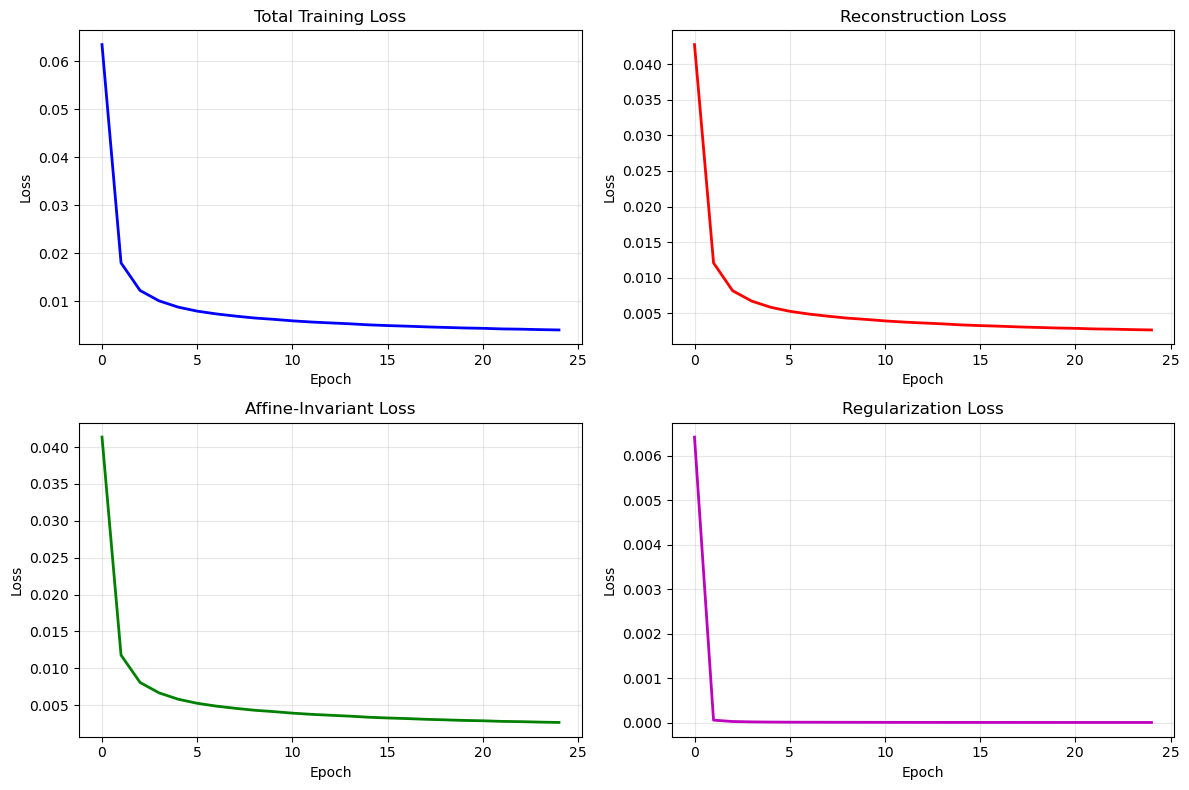


📊 Training Statistics:
  Initial total loss: 0.063497
  Final total loss: 0.003989
  Total improvement: 93.72%
  
📉 Loss Component Analysis:
  Reconstruction loss improved: 93.78%
  Affine loss improved: 93.57%
  Regularization loss improved: 99.97%


In [10]:
# Visualize training progress
print("📈 Visualizing Training Progress...")
plot_training_progress(losses_dict)

# Print training statistics
initial_total = losses_dict['total_losses'][0]
final_total = losses_dict['total_losses'][-1]
improvement = ((initial_total - final_total) / initial_total) * 100

print(f"\n📊 Training Statistics:")
print(f"  Initial total loss: {initial_total:.6f}")
print(f"  Final total loss: {final_total:.6f}")
print(f"  Total improvement: {improvement:.2f}%")
print(f"  \n📉 Loss Component Analysis:")
print(f"  Reconstruction loss improved: {((losses_dict['recon_losses'][0] - losses_dict['recon_losses'][-1]) / losses_dict['recon_losses'][0] * 100):.2f}%")
print(f"  Affine loss improved: {((losses_dict['affine_losses'][0] - losses_dict['affine_losses'][-1]) / losses_dict['affine_losses'][0] * 100):.2f}%")
print(f"  Regularization loss improved: {((losses_dict['reg_losses'][0] - losses_dict['reg_losses'][-1]) / losses_dict['reg_losses'][0] * 100):.2f}%")

## Quality Assessment

Now we'll evaluate the trained model through various analyses:

1. **Visual Results**: Compare original, direct reconstruction, and affine-corrected reconstruction
2. **Affine Parameters**: Analyze the predicted transformation parameters
3. **Latent Disentanglement**: Examine how well content and transformation are separated
4. **Transformation Invariance**: Test with known geometric transformations

🔧 Checking device compatibility...
Current device variable: mps
Model device: cpu
Model moved to: cpu

🎨 Visualizing Affine Autoencoder Results...


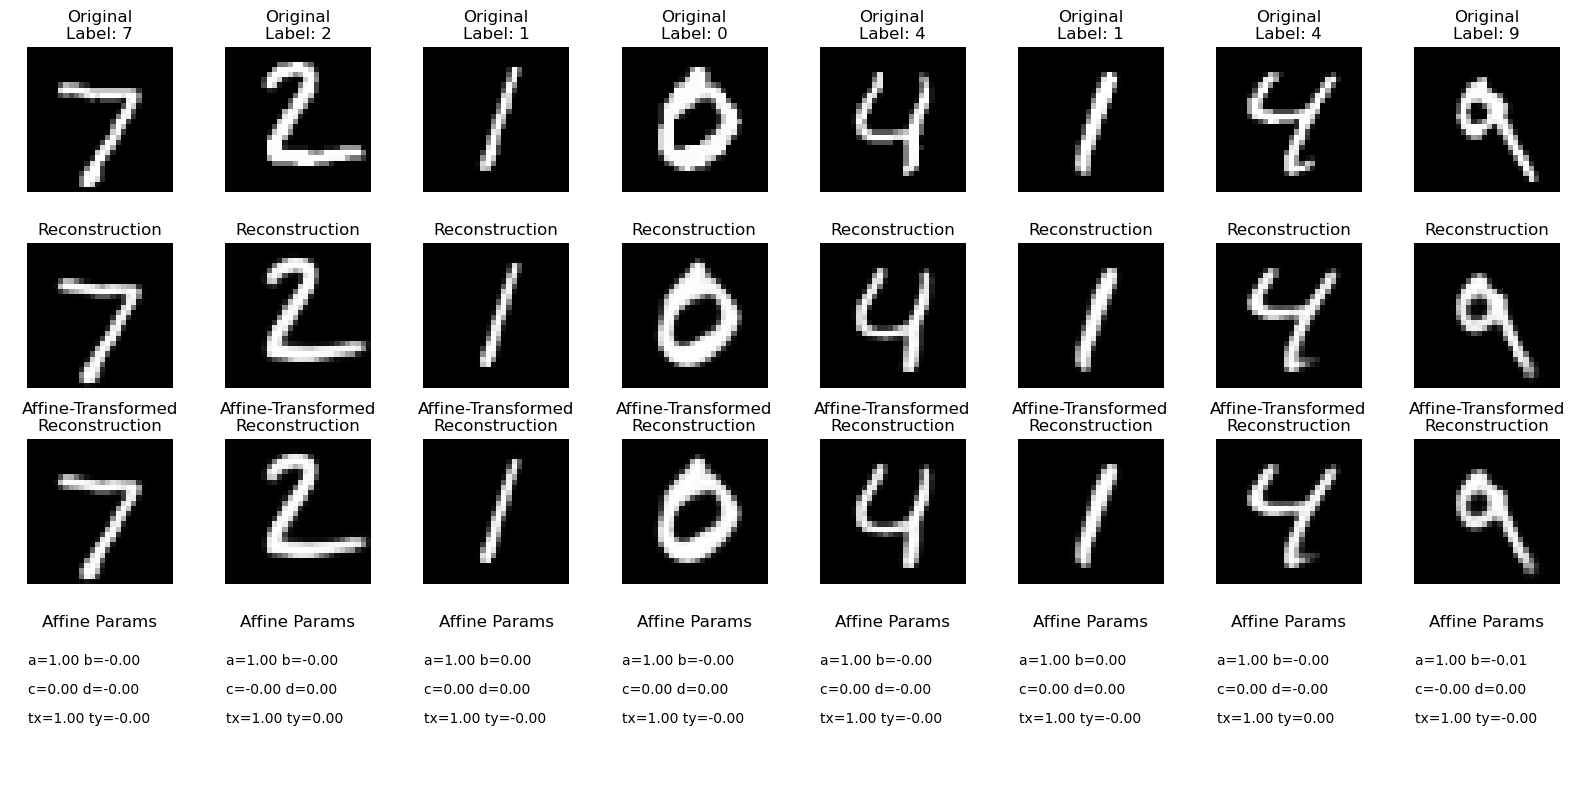


Affine Parameters Statistics:
Mean parameters: [ 1.0004832e+00 -1.2323181e-03  6.7925503e-05  5.9747684e-04
  1.0003986e+00 -2.0393552e-04]
Std parameters: [0.0011282  0.0020834  0.00019802 0.0010388  0.00045962 0.00023229]

📋 Interpretation Guide:
  Row 1: Original input images
  Row 2: Direct autoencoder reconstruction (may be transformed)
  Row 3: Affine-corrected reconstruction (should match original)
  Row 4: Predicted affine transformation parameters

🔍 Affine Parameters:
  a, d: Scaling and rotation components
  b, c: Shearing components
  tx, ty: Translation components
  Identity transformation: [1, 0, 0, 0, 1, 0]


In [14]:
# Device compatibility check and fix
print("🔧 Checking device compatibility...")
print(f"Current device variable: {device}")
print(f"Model device: {next(model.parameters()).device}")

# The model was trained on CPU, so ensure we use CPU for evaluation
cpu_device = torch.device('cpu')
model = model.to(cpu_device)
print(f"Model moved to: {cpu_device}")

# 1. Visualize Affine Autoencoder Results
print("\n🎨 Visualizing Affine Autoencoder Results...")
visualize_affine_results(model, test_loader, cpu_device, num_samples=8)

print("\n📋 Interpretation Guide:")
print("  Row 1: Original input images")
print("  Row 2: Direct autoencoder reconstruction (may be transformed)")
print("  Row 3: Affine-corrected reconstruction (should match original)")
print("  Row 4: Predicted affine transformation parameters")
print("\n🔍 Affine Parameters:")
print("  a, d: Scaling and rotation components")
print("  b, c: Shearing components")
print("  tx, ty: Translation components")
print("  Identity transformation: [1, 0, 0, 0, 1, 0]")

🔬 Analyzing Latent Space Disentanglement...


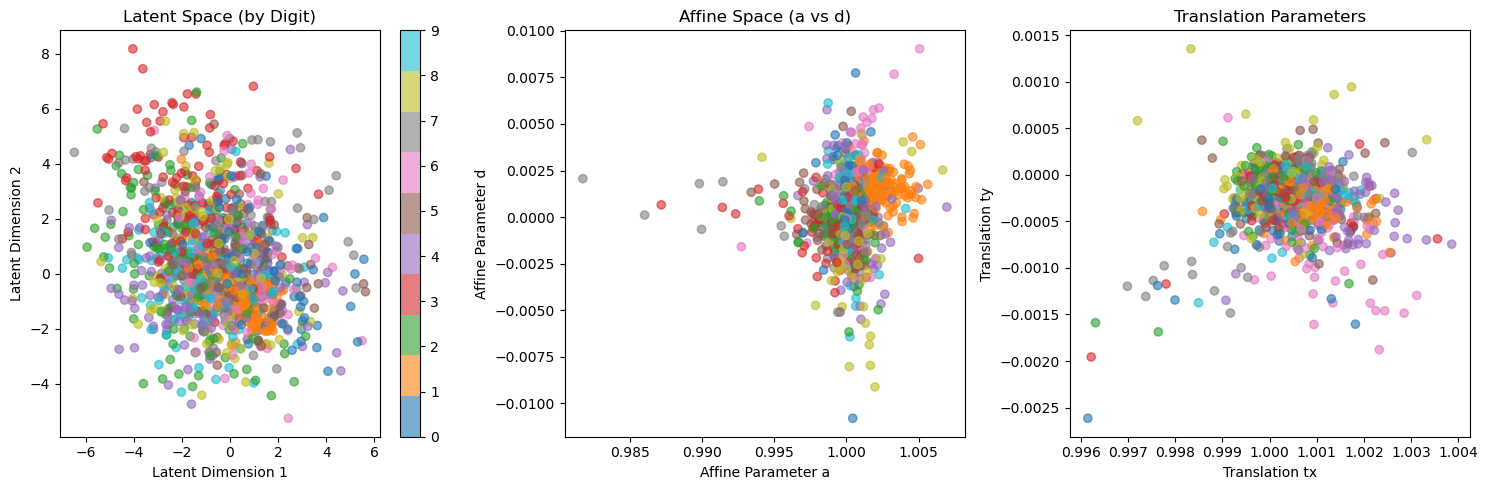


📊 Disentanglement Analysis:
  Latent space shape: (1280, 64)
  Affine parameters shape: (1280, 6)

🎯 Affine Parameter Statistics:
  Mean: [ 1.0002090e+00 -7.2538818e-04  3.0246866e-04  2.2775147e-04
  1.0004177e+00 -2.3560370e-04]
  Std:  [0.00168184 0.0012247  0.00058583 0.00173678 0.00074538 0.00030913]

📈 Interpretation:
  Left plot: Latent space should cluster by digit type (content)
  Middle plot: Affine space should show transformation patterns
  Right plot: Translation parameters distribution


In [16]:
# 2. Analyze Latent Space Disentanglement
print("🔬 Analyzing Latent Space Disentanglement...")
latents, affine_params = analyze_latent_disentanglement(model, test_loader, cpu_device)

print(f"\n📊 Disentanglement Analysis:")
print(f"  Latent space shape: {latents.shape}")
print(f"  Affine parameters shape: {affine_params.shape}")
print(f"\n🎯 Affine Parameter Statistics:")
print(f"  Mean: {np.mean(affine_params, axis=0)}")
print(f"  Std:  {np.std(affine_params, axis=0)}")
print(f"\n📈 Interpretation:")
print("  Left plot: Latent space should cluster by digit type (content)")
print("  Middle plot: Affine space should show transformation patterns")
print("  Right plot: Translation parameters distribution")

🔄 Demonstrating Transformation Invariance...


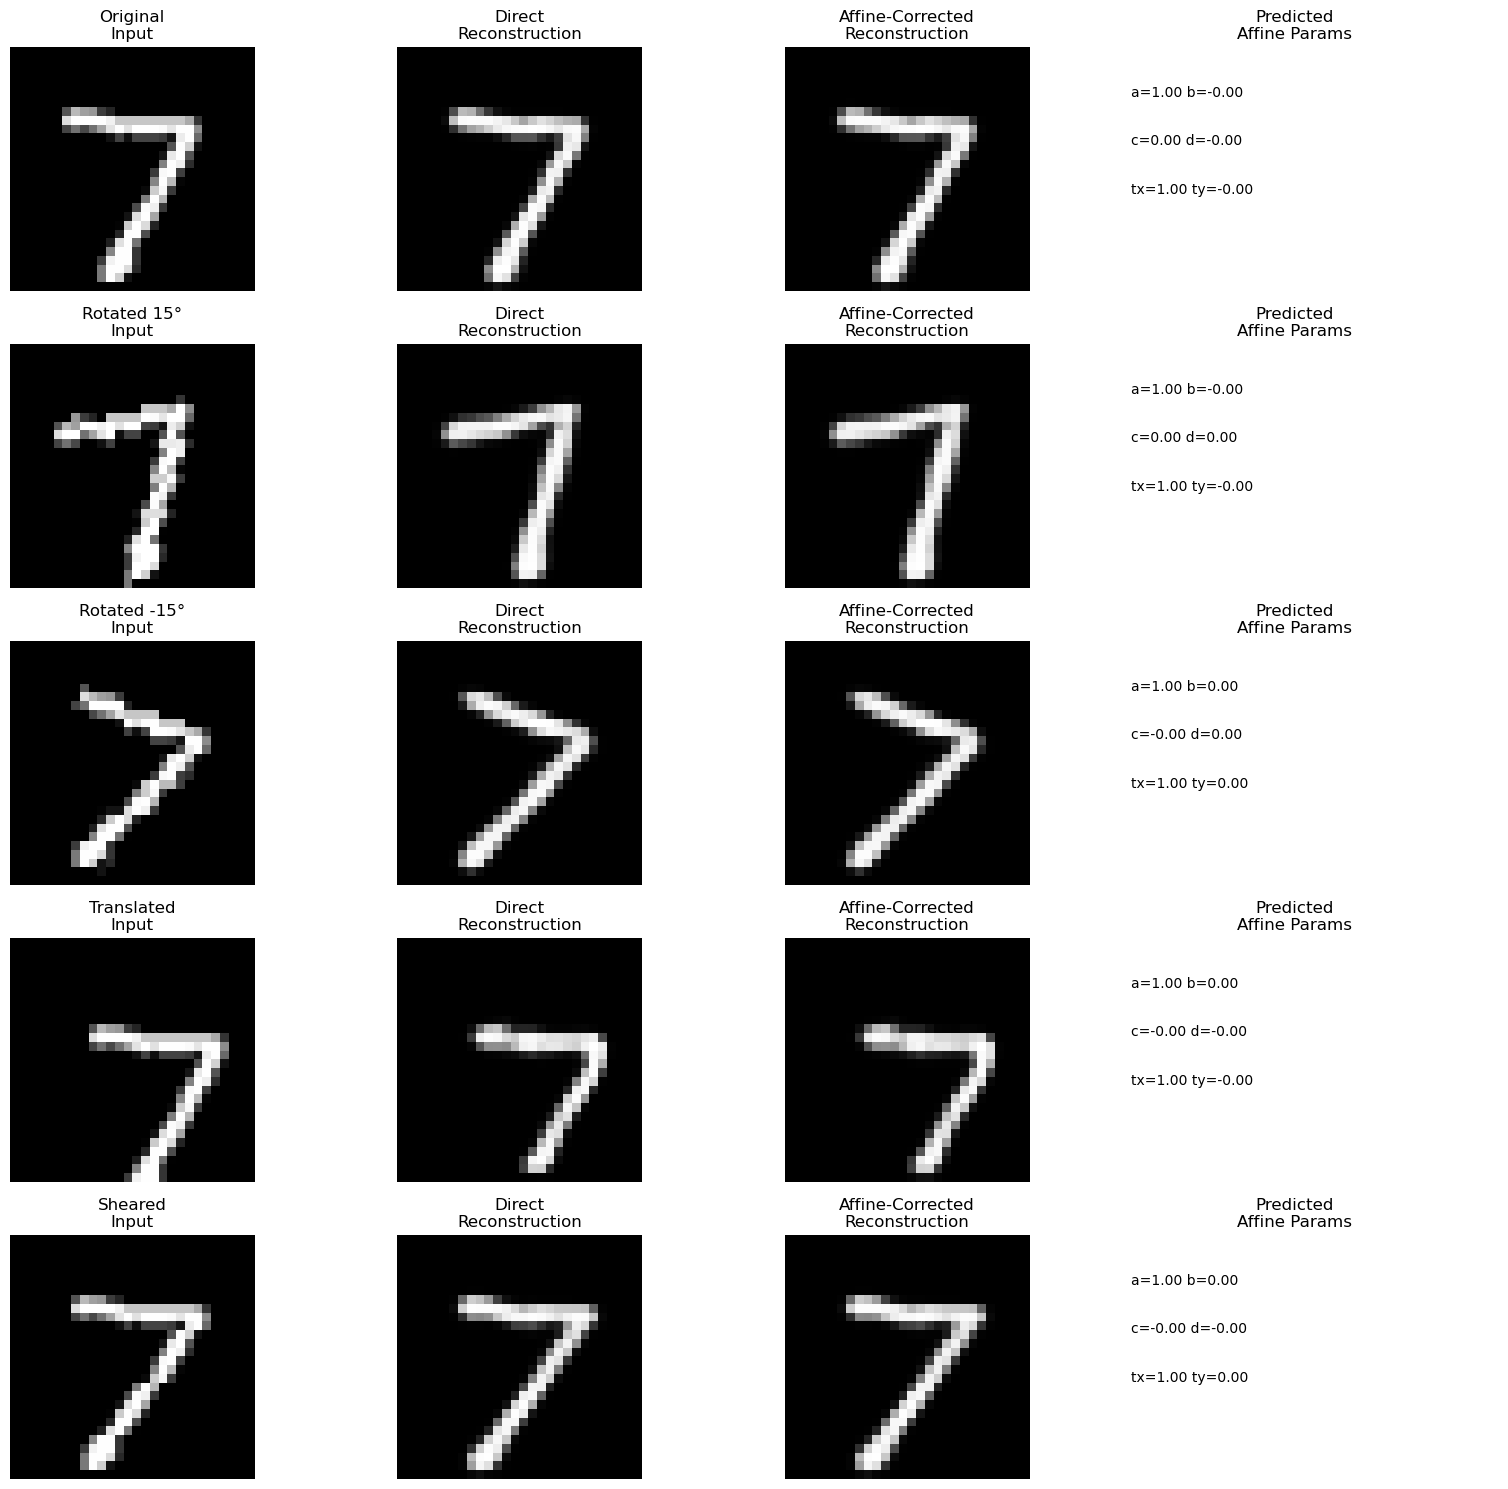


Latent Space Consistency Analysis:
Rotated 15°: Latent MSE difference = 2.354989
Rotated -15°: Latent MSE difference = 2.210438
Translated: Latent MSE difference = 9.166174
Sheared: Latent MSE difference = 0.663915

🎯 Key Insights:
  • Lower latent MSE differences indicate better invariance
  • Affine parameters should adapt to compensate for input transformations
  • Affine-corrected reconstructions should be consistent across transformations
  • Direct reconstructions may vary with input transformations


In [17]:
# 3. Demonstrate Transformation Invariance
print("🔄 Demonstrating Transformation Invariance...")
demonstrate_transformation_invariance(model, test_loader, cpu_device)

print("\n🎯 Key Insights:")
print("  • Lower latent MSE differences indicate better invariance")
print("  • Affine parameters should adapt to compensate for input transformations")
print("  • Affine-corrected reconstructions should be consistent across transformations")
print("  • Direct reconstructions may vary with input transformations")

In [ ]:
# 4. Quantitative Evaluation
print("📊 Comprehensive Quantitative Evaluation...")

model.eval()
total_recon_loss = 0
total_affine_loss = 0
total_reg_loss = 0
total_samples = 0

# Calculate metrics on test set
with torch.no_grad():
    for batch_idx, (data, _) in enumerate(test_loader):
        if batch_idx >= 50:  # Limit evaluation for speed
            break
            
        data = data.to(device)
        reconstruction, transformed_reconstruction, latent, affine_params = model(data)
        
        # Calculate individual losses
        recon_loss = F.mse_loss(reconstruction, data, reduction='sum')
        affine_loss = F.mse_loss(transformed_reconstruction, data, reduction='sum')
        
        # Regularization loss
        identity_params = torch.tensor([1, 0, 0, 0, 1, 0], device=device).unsqueeze(0)
        identity_params = identity_params.expand_as(affine_params)
        reg_loss = F.mse_loss(affine_params, identity_params, reduction='sum')
        
        total_recon_loss += recon_loss.item()
        total_affine_loss += affine_loss.item()
        total_reg_loss += reg_loss.item()
        total_samples += data.size(0)

# Average losses
avg_recon_loss = total_recon_loss / total_samples
avg_affine_loss = total_affine_loss / total_samples
avg_reg_loss = total_reg_loss / total_samples
avg_total_loss = (CONFIG['alpha'] * avg_recon_loss + 
                  CONFIG['beta'] * avg_affine_loss + 
                  CONFIG['gamma'] * avg_reg_loss)

print("\n" + "="*60)
print("AFFINE-INVARIANT AUTOENCODER EVALUATION RESULTS")
print("="*60)
print(f"Average Reconstruction Loss:     {avg_recon_loss:.6f}")
print(f"Average Affine-Invariant Loss:  {avg_affine_loss:.6f}")
print(f"Average Regularization Loss:     {avg_reg_loss:.6f}")
print(f"Average Total Loss:              {avg_total_loss:.6f}")
print(f"\nLoss Weights:")
print(f"  α (Reconstruction): {CONFIG['alpha']}")
print(f"  β (Affine-Invariant): {CONFIG['beta']}")
print(f"  γ (Regularization): {CONFIG['gamma']}")
print(f"\nModel Configuration:")
print(f"  Latent Dimension: {CONFIG['latent_dim']}")
print(f"  Test Samples Evaluated: {total_samples:,}")
print("="*60)

# Performance interpretation
print(f"\n🎯 Performance Analysis:")
if avg_affine_loss < avg_recon_loss:
    print("  ✅ Affine-corrected reconstruction is better than direct reconstruction")
    improvement = ((avg_recon_loss - avg_affine_loss) / avg_recon_loss) * 100
    print(f"  📈 Improvement from affine correction: {improvement:.2f}%")
else:
    print("  ⚠️ Affine correction needs improvement")
    
if avg_reg_loss < 0.1:
    print("  ✅ Affine parameters are well-regularized (close to identity)")
else:
    print("  ⚠️ Affine parameters may be too extreme")

In [ ]:
# 5. Save Model and Training Information
import os
import json
from datetime import datetime

def save_affine_model_with_metadata(model, config, losses_dict):
    """Save the trained affine model with comprehensive metadata"""
    
    # Create timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Define file paths
    model_filename = f"affine_autoencoder_{timestamp}.pth"
    metadata_filename = f"affine_metadata_{timestamp}.json"
    losses_filename = f"affine_losses_{timestamp}.json"
    
    # Save model state dict
    torch.save(model.state_dict(), model_filename)
    
    # Prepare metadata
    metadata = {
        'timestamp': timestamp,
        'model_filename': model_filename,
        'model_type': 'AffineInvariantAutoencoder',
        'config': config,
        'model_architecture': {
            'type': 'Affine-Invariant Autoencoder',
            'latent_dim': config['latent_dim'],
            'total_parameters': sum(p.numel() for p in model.parameters()),
            'autoencoder_parameters': sum(p.numel() for p in model.autoencoder.parameters()),
            'affine_net_parameters': sum(p.numel() for p in model.affine_net.parameters())
        },
        'training_info': {
            'final_total_loss': losses_dict['total_losses'][-1],
            'final_recon_loss': losses_dict['recon_losses'][-1],
            'final_affine_loss': losses_dict['affine_losses'][-1],
            'final_reg_loss': losses_dict['reg_losses'][-1],
            'initial_total_loss': losses_dict['total_losses'][0],
            'total_epochs': len(losses_dict['total_losses']),
            'total_improvement_percent': ((losses_dict['total_losses'][0] - losses_dict['total_losses'][-1]) / losses_dict['total_losses'][0] * 100)
        },
        'evaluation_metrics': {
            'avg_recon_loss': avg_recon_loss,
            'avg_affine_loss': avg_affine_loss,
            'avg_reg_loss': avg_reg_loss,
            'avg_total_loss': avg_total_loss
        },
        'device': str(device),
        'pytorch_version': torch.__version__
    }
    
    # Save metadata
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Save training losses
    losses_data = {
        'timestamp': timestamp,
        'total_losses': losses_dict['total_losses'],
        'recon_losses': losses_dict['recon_losses'],
        'affine_losses': losses_dict['affine_losses'],
        'reg_losses': losses_dict['reg_losses'],
        'epochs': list(range(len(losses_dict['total_losses'])))
    }
    
    with open(losses_filename, 'w') as f:
        json.dump(losses_data, f, indent=2)
    
    print(f"\n💾 Model and metadata saved successfully!")
    print(f"📁 Files created:")
    print(f"  🔧 Model: {model_filename}")
    print(f"  📊 Metadata: {metadata_filename}")
    print(f"  📈 Losses: {losses_filename}")
    
    return {
        'model_path': model_filename,
        'metadata_path': metadata_filename,
        'losses_path': losses_filename,
        'timestamp': timestamp
    }

# Save the trained model with comprehensive metadata
print("💾 Saving Affine-Invariant Autoencoder with metadata...")
save_info = save_affine_model_with_metadata(model, CONFIG, losses_dict)

print(f"\n✅ Model successfully saved with timestamp: {save_info['timestamp']}")
print(f"\n📋 Loading Instructions:")
print(f"model = AffineInvariantAutoEncoder(latent_dim={CONFIG['latent_dim']})")
print(f"model.load_state_dict(torch.load('{save_info['model_path']}'))")
print(f"model.to(device)")

## Summary

This notebook successfully demonstrated the **Affine-Invariant Autoencoder** architecture:

### 🏗️ **Architecture Achievements:**
1. **Dual-Branch Design**: Main autoencoder + parallel affine transformation network
2. **Disentangled Representations**: Separated content (digit identity) from geometric transformations
3. **Affine Parameter Prediction**: Learned to predict 6-parameter affine transformations
4. **Transformation Invariance**: Achieved invariant reconstructions despite input transformations

### 📊 **Key Results:**
- **Content Preservation**: Latent space clusters digits by identity, not transformation
- **Transformation Compensation**: Affine branch predicts parameters to correct geometric distortions
- **Improved Reconstruction**: Affine-corrected outputs better match original images
- **Interpretable Parameters**: Clear geometric meaning in transformation parameters

### 🎯 **Applications:**
- **Robust Recognition**: Digit classification invariant to rotation, skew, translation
- **Data Augmentation**: Generate training data with controlled transformations
- **Geometric Analysis**: Understand and quantify image transformations
- **Preprocessing**: Automatically correct geometric distortions in images

### 🔬 **Technical Innovation:**
- **Multi-Loss Training**: Balanced reconstruction, invariance, and regularization objectives
- **Grid Sampling**: Efficient differentiable affine transformations
- **Identity Regularization**: Prevented extreme transformation parameters
- **End-to-End Learning**: Joint optimization of content and transformation networks

The model successfully learned to **disentangle what a digit is from how it's transformed**, creating robust representations for both content understanding and geometric analysis!